# Setup

In [20]:
%load_ext autoreload
%autoreload 2

# general/plotting
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np

# gee functions
import ee
import folium
import geemap
import gee_utils
# Authenticate to Earth Engine
ee.Authenticate()
# Initialize Earth Engine instance
ee.Initialize(project="reeftruth")

#!!! (for readme)
# https://stackoverflow.com/questions/78374548/no-authentication-box-appears-when-authenticating-google-earth-engine-gee-pyth

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = gee_utils.add_ee_layer

# Vis params and AOIs

In [3]:
### Visualisation params
# harmonized sentinel-2 bands
sVisParams = {
  "min": 0,
  "max": 3000,
  "gamma": 1.5,
  "bands": ["B4", "B3", "B2"]
}
# Define the bands to be used
sBands = ["B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A"]
# PRSIM benthic classes
prismVisParams = {
  "min": 0,
  "max": 1,
  "color": ["red", "green", "blue"],
};
# PRSIM benthic classes
coralVisParams = {
  "min": 0,
  "max": 1,
  "palette": ["FFFFFF01", "cc0000"],
};
algaeVisParams = {
  "min": 0,
  "max": 1,
  "palette": ["FFFFFF01", "009933"],
};
sandVisParams = {
  "min": 0,
  "max": 1,
  "palette": ["FFFFFF01", "ffcc66"],
};
bathVisParams = {
    "min": -50,
    "max": 10,
    "palette": [
    "#e0f8f8",  # Light Aqua
    "#b2f4f4",  # Light Cyan
    "#00b2e1",  # Turquoise
    "#a0c5e8",  # Light Blue
    "#cfe0f5"   # Pale Blue
]
    # "palette": ["0000ff", "00ffff", "ffff00", "ff0000", "ffffff"]
}

### aoi_geom
# Define bounds
swains_bounds = [[151.9006776532874, -22.425424797331246],
          [152.83451554391243, -22.425424797331246],
          [152.83451554391243, -21.408761467649015],
          [151.9006776532874, -21.408761467649015],
          [151.9006776532874, -22.425424797331246]]
swains_aoi = ee.Geometry.Polygon(swains_bounds)


# Sentinel basemap

In [8]:
import ee
import geemap

# set aoi_geom
aoi_geom = swains_aoi

# Define the Sentinel-2 Image Collection and Cloud Collection
sentinel_collection = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") # Level 1C, 2015-2024
sentinel_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") # Level 2A, 2017-2024
sentinel_clouds = ee.ImageCollection("GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED")

# Filter satellite timeseries for best image
sentinel_colour = sentinel_collection.filterDate("2022-01-01", "2023-01-01") \
    .filterBounds(aoi_geom)  \
    .linkCollection(sentinel_clouds, ["cs_cdf"]) \
    .map(lambda image: image.updateMask(image.select("cs_cdf").gt(0.6)))

composite = sentinel_colour.median()

# Calculate NDWI to mask land
ndwi = composite.expression(
    '(GREEN - NIR) / (GREEN + NIR)',
    {
        'GREEN': composite.select('B3'),
        'NIR': composite.select('B8')
    }
)

# Sunglint correction and water mask
water_image = composite.updateMask(ndwi.gt(0.1)).select(['B4', 'B3', 'B2']).subtract(composite.select('B8'))
sunglint_correction = composite.select(['B4', 'B3', 'B2']).subtract(composite.select('B8'))

# Add layers to the map
Map = geemap.Map(height='1000px')
Map.addLayer(water_image.clip(aoi_geom), sVisParams, '(NDWI) satellite-derived land mask')
Map.addLayer(composite.clip(aoi_geom), sVisParams, 'sentinel composite')
Map.addLayer(sunglint_correction.clip(aoi_geom), sVisParams, 'tow R', False)

# Uncomment below to use the RF-based mask
# masked_img = gee_utils.landmask(composite.clip(aoi_geom))
# Map.addLayer(masked_img, sVisParams, 'satellite-derived land mask (RF)', False)
# Map

# Bathymetry

In [11]:
# load relevant bathymetry data
bath = ee.Image("projects/reeftruth/assets/PRISM/Great_Barrier_Reef_C_2020_30m_MSL_cog")

# add bathymetry to map
Map.addLayer(bath.clip(aoi_geom), bathVisParams, 'bathymetry')
# Map.centerObject(aoi_geom, 11)
# Map

# PRISM data

In [13]:
swains = ee.Image("projects/reeftruth/assets/PRISM/Swains").rename(['coral', 'algae', 'sand'])
Map.addLayer(swains, prismVisParams, 'PRISM benthic classes')

In [14]:
# get bands from swains
swains_flight_bounds = swains.get("system:footprint").getInfo().get("coordinates")
swains_flight_bounds_geometry = ee.Geometry.Polygon(swains_flight_bounds)
# create sunglint_correction cropped to swains bounds
swains_aoi_sunglint_correction = sunglint_correction.clip(swains_flight_bounds_geometry)
Map.addLayer(swains_aoi_sunglint_correction, sVisParams, 'tow R (swains bounds)', False)

In [15]:
Map.centerObject(aoi_geom, 11)
Map

Map(bottom=294871.0, center=[-21.91714700361253, 152.36759659859993], controls=(WidgetControl(options=['positi…

## Local tif exploration

In [16]:
# investigate swains data from local file
swains_fp = ("/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/reeftruth/data/prism/processed/Swains.tif")
swains_tif = rio.open(swains_fp)

gee_utils.inspect_tif(swains_tif)
band_dict = gee_utils.process_tif(swains_tif)
band1, band2, band3 = band_dict["b1"], band_dict["b2"], band_dict["b3"]

DIMENSIONS | height:  8746 width:  4800
BOUNDS |  BoundingBox(left=439970.9292, bottom=7522167.0671, right=477410.9292, top=7590385.8671)
BANDS | count:  3
DATA TYPE(S) |  {1: 'float32', 2: 'float32', 3: 'float32'}
CRS |  EPSG:32756
TRANSFORM |  | 7.80, 0.00, 439970.93|
| 0.00,-7.80, 7590385.87|
| 0.00, 0.00, 1.00|


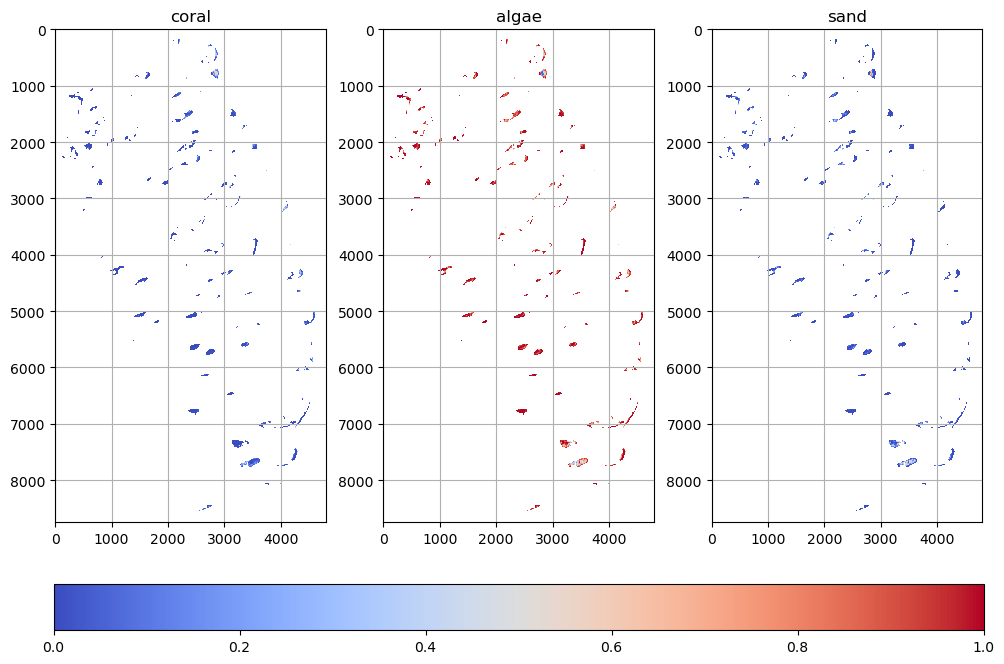

In [17]:
f, ax = plt.subplots(ncols=3, figsize=(12, 8))
im1 = ax[0].imshow(band1, cmap='coolwarm', vmin=0, vmax=1)
ax[0].set_title('coral')
im2 = ax[1].imshow(band2, cmap='coolwarm', vmin=0, vmax=1)
ax[1].set_title('algae')
im3 = ax[2].imshow(band3, cmap='coolwarm', vmin=0, vmax=1)
ax[2].set_title('sand')

for a in ax:
    a.grid()
    
f.colorbar(im1, ax=ax, orientation='horizontal', fraction=0.1, pad=0.1)

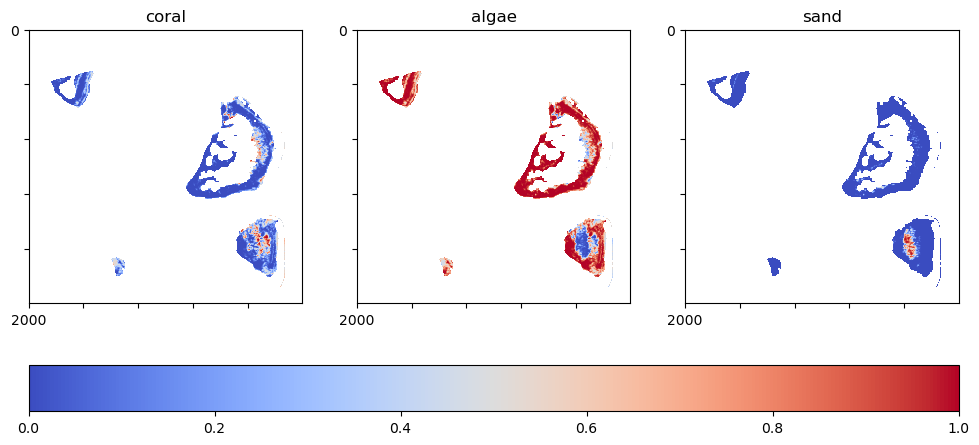

In [18]:
zoom_inds = [0, 1000, 2000, 3000]
zoom_band1, zoom_band2, zoom_band3 = band1[zoom_inds[0]:zoom_inds[1], zoom_inds[2]:zoom_inds[3]], band2[zoom_inds[0]:zoom_inds[1], zoom_inds[2]:zoom_inds[3]], band3[zoom_inds[0]:zoom_inds[1], zoom_inds[2]:zoom_inds[3]]

f, ax = plt.subplots(ncols=3, figsize=(12, 8))
im1 = ax[0].imshow(zoom_band1, cmap='coolwarm', vmin=0, vmax=1)
# relabel axis ticks with the axes of the original image
ax[0].set_title('coral')
im2 = ax[1].imshow(zoom_band2, cmap='coolwarm', vmin=0, vmax=1)
ax[1].set_title('algae')
im3 = ax[2].imshow(zoom_band3, cmap='coolwarm', vmin=0, vmax=1)
ax[2].set_title('sand')
    
for a in ax:
    a.set_yticklabels([1000, 0])
    a.set_xticklabels([3000, 2000])


f.colorbar(im1, ax=ax, orientation='horizontal', fraction=0.1, pad=0.1)


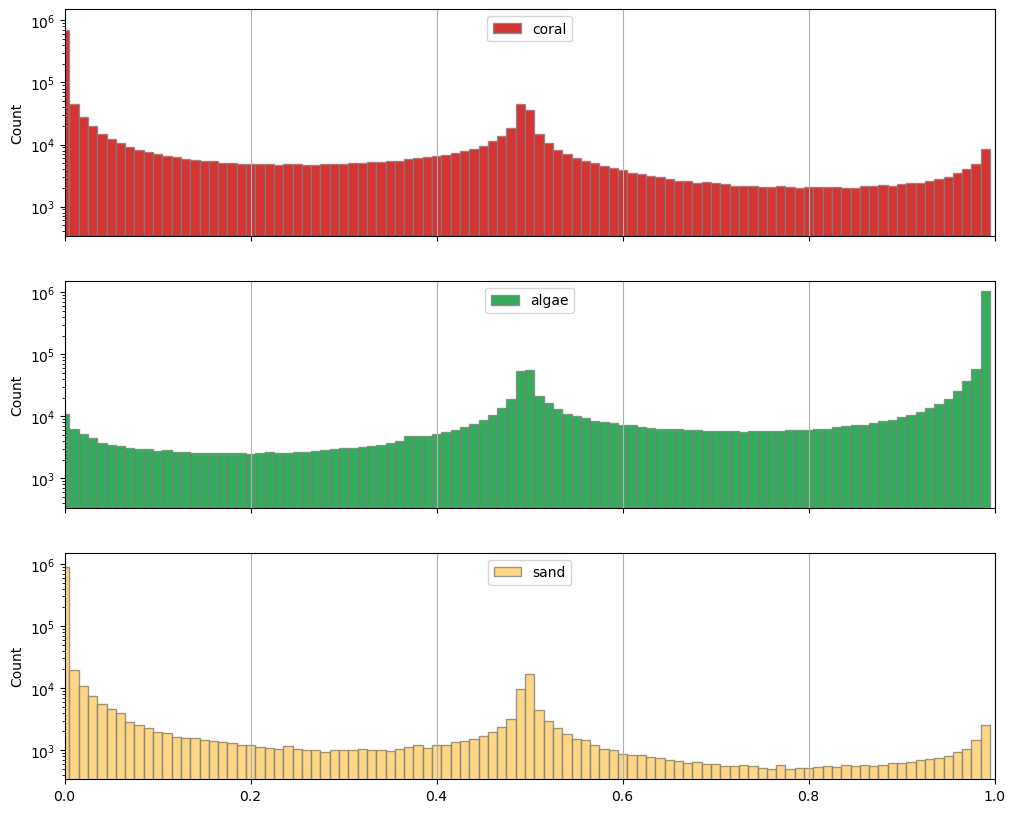

In [21]:
f, ax = plt.subplots(nrows=3, figsize=(12, 10), sharex=True, sharey=True)
nbins = 100
class_colours = {"coral": "#cc0000", "algae": "#009933", "sand": "#ffcc66"}

for b, band in enumerate(class_colours.keys()):
    band_data = swains.select(band)
    hist_values, hist_counts = gee_utils.get_value_distribution(band_data, swains_aoi)
    # resample the histogram
    new_bin_edges, new_bin_counts = gee_utils.resample_histogram(hist_values, hist_counts, nbins)
    ax[b].bar(new_bin_edges[:-1], new_bin_counts, width=np.diff(new_bin_edges), color=class_colours[band], alpha=0.8, label=band, edgecolor='grey')
    ax[b].set_yscale("log")
    ax[b].legend(loc="upper center")
    ax[b].set_xlim(0, 1)
    ax[b].grid(axis='x')
    ax[b].set_ylabel("Count")

In [22]:
# visualise PRISM layers
Map.addLayer(gee_utils.alpha_band(swains, "algae"), algaeVisParams, 'algae')
Map.addLayer(gee_utils.alpha_band(swains, "coral"), coralVisParams, 'coral')
Map.addLayer(gee_utils.alpha_band(swains, "sand"), sandVisParams, 'sand')
Map

Map(bottom=295371.0, center=[-21.91714700361253, 152.36759659859993], controls=(WidgetControl(options=['positi…

# Classification

In [ ]:
# TODO:
# - mask depth via PRISM (else may see classes which haven't been classified)
# - add to map
# - PCA on bands
# - split into test and train sets
# - train ee RF model
# - export relevant imagery to drive
# - train sklearn RF model locally (https://geemap.org/notebooks/46_local_rf_training/)
# - transfer model to EE